epoch  0 complete
loss: tf.Tensor(1.1377099, shape=(), dtype=float32) d_loss:  tf.Tensor(0.6184919, shape=(), dtype=float32)
condition  Dress


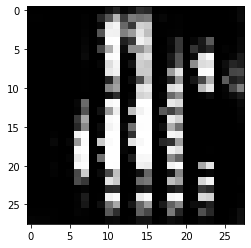

epoch  1 complete
loss: tf.Tensor(4.6402693, shape=(), dtype=float32) d_loss:  tf.Tensor(0.019769674, shape=(), dtype=float32)
condition  Dress


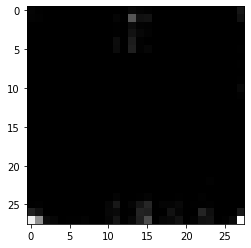

epoch  2 complete
loss: tf.Tensor(6.433007, shape=(), dtype=float32) d_loss:  tf.Tensor(0.004424053, shape=(), dtype=float32)
condition  Dress


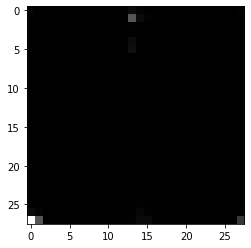

KeyboardInterrupt: 

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

dataset, info = tfds.load("fashion_mnist", split="train", with_info=True)


def convert(row):
    image = tf.image.convert_image_dtype(row["image"], tf.float32)
    label = tf.expand_dims(tf.cast(row["label"], tf.float32), axis=-1)
    return image, label


batch_size = 32
dataset = dataset.map(convert).batch(batch_size).prefetch(1)


def get_generator(latent_dimension):

    # Condition subnetwork: encode the condition in a hidden representation
    condition = tf.keras.layers.Input((1,))
    net = tf.keras.layers.Dense(32, activation=tf.nn.elu)(condition)
    net = tf.keras.layers.Dense(64, activation=tf.nn.elu)(net)

    # Concatenate the hidden condition representation to noise and upsample
    noise = tf.keras.layers.Input(latent_dimension)
    inputs = tf.keras.layers.Concatenate()([noise, net])

    # Convert inputs from (batch_size, latent_dimension + 1)
    # To a 4-D tensor, that can be used with convolutions
    inputs = tf.keras.layers.Reshape((1, 1, inputs.shape[-1]))(inputs)

    depth = 128
    kernel_size = 5
    net = tf.keras.layers.Conv2DTranspose(
        depth, kernel_size, padding="valid", strides=1, activation=tf.nn.relu
    )(
        inputs
    )  # 5x5
    net = tf.keras.layers.Conv2DTranspose(
        depth // 2, kernel_size, padding="valid", strides=2, activation=tf.nn.relu
    )(
        net
    )  # 13x13
    net = tf.keras.layers.Conv2DTranspose(
        depth // 4,
        kernel_size,
        padding="valid",
        strides=2,
        activation=tf.nn.relu,
        use_bias=False,
    )(
        net
    )  # 29x29
    # Standard convolution with a 2x2 kernel to obtain a 28x28x1 out
    # The output is a sigmoid, since the images are in the [0,1] range
    net = tf.keras.layers.Conv2D(
        1, 2, padding="valid", strides=1, activation=tf.nn.sigmoid, use_bias=False
    )(net)
    model = tf.keras.Model(inputs=[noise, condition], outputs=net)
    return model


latent_dimension = 100
G = get_generator(latent_dimension)


def get_discriminator():
    # Encoder subnetwork: feature extactor to get a feature vector
    image = tf.keras.layers.Input((28, 28, 1))
    depth = 32
    kernel_size = 3
    net = tf.keras.layers.Conv2D(
        depth, kernel_size, padding="same", strides=2, activation=tf.nn.relu
    )(
        image
    )  # 14x14x32
    net = tf.keras.layers.Conv2D(
        depth * 2, kernel_size, padding="same", strides=2, activation=tf.nn.relu
    )(
        net
    )  # 7x7x64

    net = tf.keras.layers.Conv2D(
        depth * 3, kernel_size, padding="same", strides=2, activation=tf.nn.relu
    )(
        net
    )  # 4x4x96

    feature_vector = tf.keras.layers.Flatten()(net)  # 4*4*96

    # Create a hidden representation of the condition
    condition = tf.keras.layers.Input((1,))
    hidden = tf.keras.layers.Dense(32, activation=tf.nn.elu)(condition)
    hidden = tf.keras.layers.Dense(64, activation=tf.nn.elu)(hidden)

    # Concatenate the feature vector and the hidden label representatio
    out = tf.keras.layers.Concatenate()([feature_vector, hidden])

    # Add the final classification layers with a single linear neuron
    out = tf.keras.layers.Dense(128, activation=tf.nn.relu)(out)
    out = tf.keras.layers.Dense(1)(out)

    model = tf.keras.Model(inputs=[image, condition], outputs=out)
    return model


D = get_discriminator()

bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def d_loss(d_real, d_fake):
    """The disciminator loss function."""
    return bce(tf.ones_like(d_real), d_real) + bce(tf.zeros_like(d_fake), d_fake)


def g_loss(generated_output):
    """The Generator loss function."""
    return bce(tf.ones_like(generated_output), generated_output)


# Commented out IPython magic to ensure Python compatibility.
import matplotlib.pyplot as plt

# %matplotlib inline


def train():
    # Define the optimizers and the train operations
    optimizer = tf.keras.optimizers.Adam(1e-5)

    @tf.function
    def train_step(image, label):
        with tf.GradientTape(persistent=True) as tape:
            noise_vector = tf.random.normal(
                mean=0, stddev=1, shape=(image.shape[0], latent_dimension)
            )
            # Sample from the Generator
            fake_data = G([noise_vector, label])
            # Compute the D loss
            d_fake_data = D([fake_data, label])
            d_real_data = D([image, label])

            d_loss_value = d_loss(d_real_data, d_fake_data)
            # Compute the G loss
            g_loss_value = g_loss(d_fake_data)
        # Now that we comptuted the losses we can compute the gradient (using the tape)
        # and optimize the networks
        d_gradients = tape.gradient(d_loss_value, D.trainable_variables)
        g_gradients = tape.gradient(g_loss_value, G.trainable_variables)
        # Deletng the tape, since we defined it as persistent (because we used it twice)
        del tape

        optimizer.apply_gradients(zip(d_gradients, D.trainable_variables))
        optimizer.apply_gradients(zip(g_gradients, G.trainable_variables))
        return g_loss_value, d_loss_value, fake_data[0], label[0]

    epochs = 50
    for epoch in range(epochs):
        for image, label in dataset:
            g_loss_value, d_loss_value, generated, condition = train_step(image, label)

        print("epoch ", epoch, "complete")
        print("loss:", g_loss_value, "d_loss: ", d_loss_value)
        print(
            "condition ",
            info.features["label"].int2str(
                tf.squeeze(tf.cast(condition, tf.int32)).numpy()
            ),
        )
        plt.imshow(tf.squeeze(generated).numpy(), cmap="gray")
        plt.show()


train()